<a href="https://colab.research.google.com/github/kokanishiv/ds_shivnayan_kokani/blob/main/notebook_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Setup complete
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2644 entries, 0 to 2643
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   timestamp       2644 non-null   int64 
 1   value           2644 non-null   int64 
 2   classification  2644 non-null   object
 3   date            2644 non-null   object
dtypes: int64(2), object(2)
memory usage: 82.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Account           211224 non-null  object 
 1   Coin              211224 non-null  object 
 2   Execution Price   211224 non-null  float64
 3   Size Tokens       211224 non-null  float64
 4   Size USD          211224 non-null  float64
 5   Side              211224 non-null  object 
 6   Timestamp IST     211224 non-null  object 
 7   Start Position  

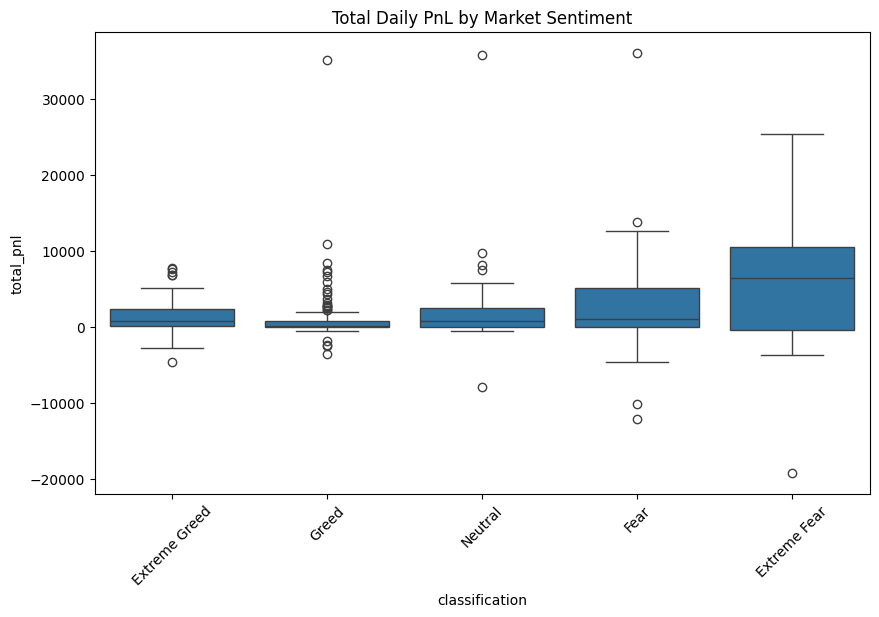

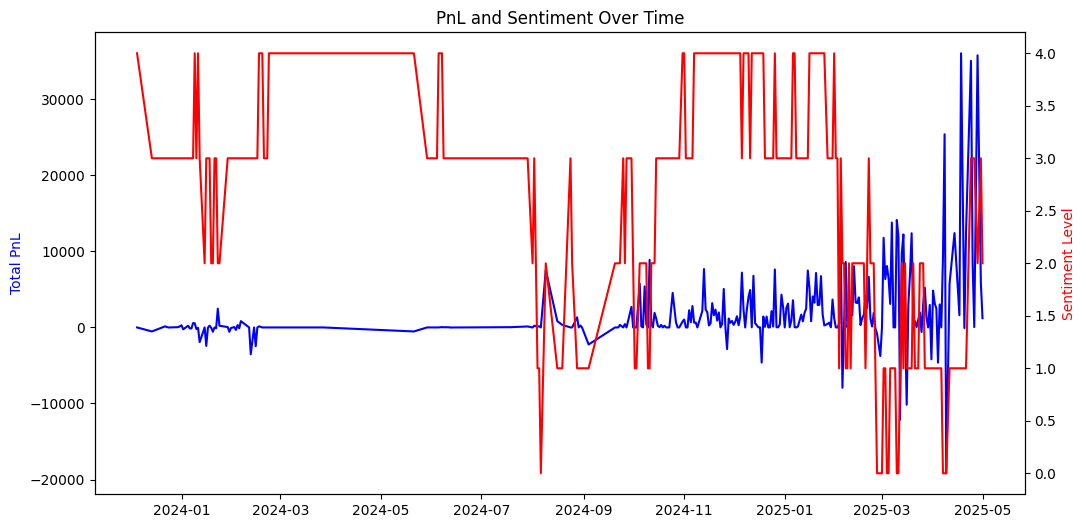

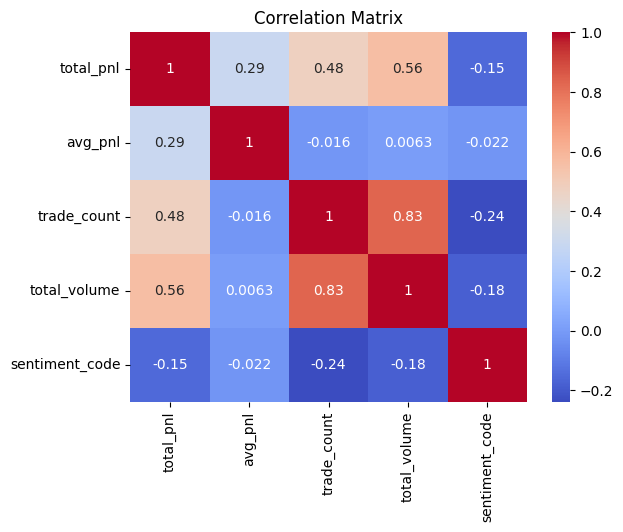

ANOVA for PnL by Sentiment: F=2.07, p=0.0844
                            OLS Regression Results                            
Dep. Variable:              total_pnl   R-squared:                       0.321
Model:                            OLS   Adj. R-squared:                  0.313
Method:                 Least Squares   F-statistic:                     42.61
Date:                Wed, 31 Dec 2025   Prob (F-statistic):           1.37e-22
Time:                        14:18:20   Log-Likelihood:                -2690.5
No. Observations:                 275   AIC:                             5389.
Df Residuals:                     271   BIC:                             5403.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

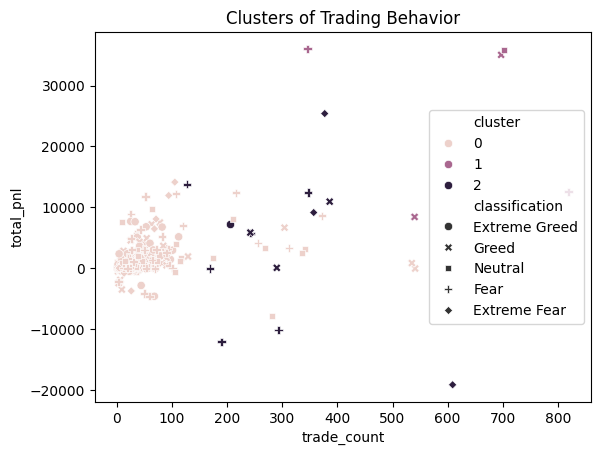

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("Setup complete")

# Load datasets
sentiment_df = pd.read_csv('/content/fear_greed_index (1).csv')
trader_df = pd.read_csv('/content/historical_data (1).csv')

# Preview data
sentiment_df.head(), trader_df.head()

sentiment_df.info()
trader_df.info()

sentiment_df.columns
trader_df.columns

sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])

trader_df['Timestamp IST'] = pd.to_datetime(trader_df['Timestamp IST'], format="%d-%m-%Y %H:%M")

trader_df = trader_df[trader_df['Coin'].str.contains('BTC', na=False)]

trader_df = trader_df.dropna(subset=['Closed PnL'])

trader_df.shape

trader_df['trade_date'] = trader_df['Timestamp IST'].dt.date

sentiment_df['date'] = sentiment_df['date'].dt.date

# Aggregate trader data by date (since sentiment is daily)
# This creates daily summaries for PnL, trade count, etc.
daily_trader = merged_df.groupby('trade_date').agg(
    total_pnl=('Closed PnL', 'sum'),
    avg_pnl=('Closed PnL', 'mean'),
    trade_count=('Closed PnL', 'count'),
    total_volume=('Size USD', 'sum')).reset_index()

# Merge with sentiment again (now aggregated)
final_df = daily_trader.merge(
    sentiment_df,
    left_on='trade_date',
    right_on='date',
    how='inner'
)
print("Final Merged Data Shape:", final_df.shape)
print(final_df.head())

# Handle any remaining NaNs or outliers
final_df.dropna(inplace=True)
# Optional: Remove extreme outliers in PnL (e.g., beyond 3 std devs)
final_df = final_df[np.abs(final_df['total_pnl'] - final_df['total_pnl'].mean()) <= (3 * final_df['total_pnl'].std())]

# EDA: Summary stats and distributions
print(final_df.describe())
print(final_df['classification'].value_counts())
final_df.to_csv('/content/final_merged_data.csv', index=False)
print("Final merged data exported to /content/final_merged_data.csv")

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# 1. PnL distribution by sentiment
plt.figure(figsize=(10, 6))
sns.boxplot(data=final_df, x='classification', y='total_pnl')
plt.title('Total Daily PnL by Market Sentiment')
plt.xticks(rotation=45)
plt.show()

# 2. Time series: PnL and sentiment over time
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(final_df['trade_date'], final_df['total_pnl'], color='blue', label='Total PnL')
ax1.set_ylabel('Total PnL', color='blue')
ax2 = ax1.twinx()
# Encode sentiment for plotting (e.g., Fear=0, Greed=1, etc.)
sentiment_map = {'Extreme Fear': 0, 'Fear': 1, 'Neutral': 2, 'Greed': 3, 'Extreme Greed': 4}
final_df['sentiment_code'] = final_df['classification'].map(sentiment_map)
ax2.plot(final_df['trade_date'], final_df['sentiment_code'], color='red', label='Sentiment Level')
ax2.set_ylabel('Sentiment Level', color='red')
plt.title('PnL and Sentiment Over Time')
plt.show()

# 3. Correlation heatmap
corr_cols = ['total_pnl', 'avg_pnl', 'trade_count', 'total_volume', 'sentiment_code']
corr_matrix = final_df[corr_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Advanced Analysis: Statistical Tests
from scipy.stats import f_oneway

# ANOVA: Test if PnL differs significantly by sentiment
groups = [final_df[final_df['classification'] == cat]['total_pnl'] for cat in final_df['classification'].unique()]
f_stat, p_val = f_oneway(*groups)
print(f"ANOVA for PnL by Sentiment: F={f_stat:.2f}, p={p_val:.4f}")
if p_val < 0.05:
    print("Significant differences in PnL across sentiment levels!")

# Regression: Predict PnL
import statsmodels.api as sm
X = final_df[['sentiment_code', 'trade_count', 'total_volume']]
X = sm.add_constant(X)
y = final_df['total_pnl']
model = sm.OLS(y, X).fit()
print(model.summary())

# Clustering: Identify patterns in trading behavior
from sklearn.cluster import KMeans
features = final_df[['total_pnl', 'trade_count', 'total_volume']]
kmeans = KMeans(n_clusters=3, random_state=42)
final_df['cluster'] = kmeans.fit_predict(features)
sns.scatterplot(data=final_df, x='trade_count', y='total_pnl', hue='cluster', style='classification')
plt.title('Clusters of Trading Behavior')
plt.show()
